# How Much of a Bottleneck is the HDFS Namenode?

There is evidence that the metadata server in HDFS, i.e. the Namenode, is a bottleneck for large Hadoop jobs. One of the issues is that Namenode is designed for only one server. In addition to the scalability (e.g., number of files) and resilience (e.g., single-point-of-failure) issues, this architecture makes it easy for clients to overload one server. These 'hotspots' and 'flash crowds' occur at the beginning of every job as `map` tasks hammer the Namenode with metadata requests. 

Long term analysis Hadoop jobs are not encouraging for the future of the single-node Namenode architecture. Hadoop jobs have high file churn, quickly changing files, and a small number of files getting the most activity [1]. The recent attention to POSIX metadata intensive workloads in academia in both the HPC community and the cloud world attests to the importance of metadata systems in large-scale systems [2].

Here we evaluate whether the multi-node subtree partitioning techniques used in Ceph is overkill or not [3]. First, we must decide whether the HDFS Namenode really is a bottleneck or not.


[1] Mimesis, MapReduce: https://sites.google.com/site/cristinaabad/

[2] IndexFS, ShardFS: http://www.pdl.cmu.edu/indexfs/index.shtml

[3] Hadoop+Ceph: https://www.usenix.org/system/files/login/articles/73508-maltzahn.pdf)

# Write Job

This Hadoop job writes random strings into *n* files in HDFS, where *n* is the number of nodes in the cluster. This benchmark stresses the overhead of the Hadoop framework because all nodes will hit the Namenode at the start of the job. To emphasize the unimportance of the actual map job, we start with an absurdly small task (write 10 bytes).

In [2]:
with open("../workloads/randomtextwriter.yml", 'r') as f:
    print f.read()

---

- hosts: namenode
  tasks:
    - shell: "{{ hadoop }} dfsadmin -safemode leave"
    - set_fact:
        job:
          - "{{ hadoop }} jar {{ binary }} randomtextwriter -Dmapreduce.randomtextwriter.bytespermap=10 out"
          - "{{ hadoop }} dfs -ls out"
          - "{{ hadoop }} dfs -rm -r out"
        output: "randomtextwriter.out"
    - include: run-hadoop.yml



## Parsing Dependencies

In [3]:
%reset -f
import warnings, glob, os, matplotlib, datetime, pandas, numpy
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

PLOTS_ARGS = {'linewidth': 2.0}
PARSE_ARGS = {'engine': 'python', 'sep': (",|:"), 'skiprows': 13, 'names': ("sec", "val")}
NAMENODE = "issdm-12"

## Graph Helper Functions

In [5]:
def plot_whisperdb(traces):
    ax = plt.figure().add_subplot(111)    
    for fname in sorted(traces):
        trace = traces[fname]           # grab the current trace
        trace = trace[trace.sec != 0]   # ignore empty timestamps
        label = os.path.dirname(os.path.dirname(fname))
        ax.plot(trace["val"],           # plot the raw values
                label=label,            # label is the site name
                **PLOTS_ARGS)           # use above arguments
    ax.legend(loc='upper right')
    ax.set_xlabel("Time (seconds)")
    return ax

## CPU Utilization when Scaling Clients

First, plot the CPU utilization on the namenode over time. Supposedly, this is a lot of work for the Hadoop namenode.

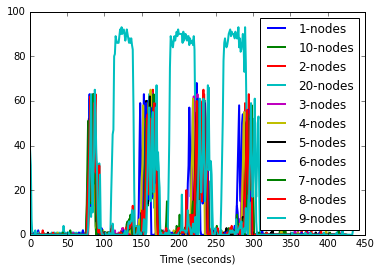

In [99]:
traces = {}
for f in glob.glob("*/utilization/cpu-*.out"):
    traces[f] = pandas.read_table(f, **PARSE_ARGS)
ax = plot_whisperdb(traces)

Ahh. Too many lines. Let's filter out some of the experiments and zoom in a little bit...

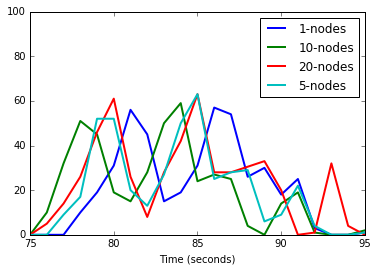

In [100]:
for site in ['2', '3', '4', '6', '7', '8', '9']:
    del traces[site + "-nodes/utilization/cpu-" + NAMENODE + ".out"]
ax = plot_whisperdb(traces)
ax = ax.set_xlim(75, 95)

### Analysis

It does not look like creates are the problem. The CPU utilization (*y* axis) does not increase with more clients; the phase with high metadata activity does not get longer (*x* axis). I have a couple expalanations: (1) we did not overload the namenode enough and (2) CPU utilization is not a good indicator of load. Let's try to address (2) by looking at the runtime of the different job phases.

## Runtime when Scaling Clients

In [101]:
def convert_to_seconds(data):
    return data.apply(lambda x: 
                      (int(x.split(':')[0]) * 360) 
                      + (int(x.split(':')[1]) * 60) 
                      + float(x.split(':')[2]))

def plot_runtimes(job):
    site = []; labl = []
    plt.figure()
    for f in sorted(glob.glob("*/raw/randomtextwriter.out")):
        data_raw = pandas.read_csv(f)
        data = data_raw[data_raw['cmd'].str.contains(job)]
        site.append(convert_to_seconds(data['delta']))
        labl.append(os.path.dirname(os.path.dirname(f)))
    plt.boxplot(site)
    plt.xticks(range(1, len(labl) + 1), labl, rotation='vertical')
    plt.ylim(bottom=0)

Plot the different phases of the job. "jar" is running the actual job and the other two are just file system operations.

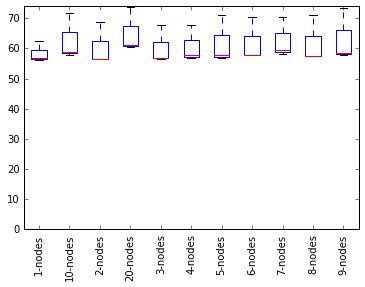

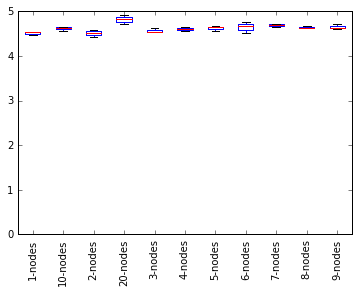

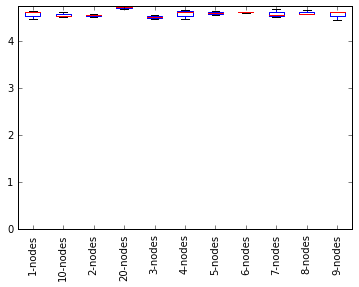

In [102]:
plot_runtimes('jar') 
plot_runtimes('-ls') 
plot_runtimes('-rm')

Again -- nothing of significance stands out here. There is no difference when we scale the number of nodes.


# Next Steps


### Add more clients
After adding more clients Interesting... how bad can we make this? It looks like the metadata operations overlap with the actual computation but could we make this worse? Maybe if I add more nodes all over the place.

### Dive deeper into the remove/ls

### Intermediate data?